# Initialization cells
Follows are initialization cells to
- Reset the package directory
- Reload the k-seq package

Some updates need to be done manually:
- If any change made in the object, all inherent objects needs to be reassigned

In [29]:
import sys
import numpy as np
# add package directory to the top of sys.path
if np.sum([dirc.find('k-seq') >= 0 for dirc in sys.path]) == 0:
    sys.path = ['/home/yuning/Work/k-seq/src/'] + sys.path

import util
import importlib
import k_seq.data.pre_processing as pre_processing
import k_seq.data.analysis as analysis
import k_seq.fitting.analysis as fit_analysis
import k_seq.data.io as io
importlib.reload(pre_processing)# refresh data module
importlib.reload(analysis)# refresh data module
importlib.reload(fit_analysis)

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

# Sequencing sample analysis
## import samples

In [22]:
# read counts files into sample_set
sample_set = pre_processing.load_count_files(
    file_root='/mnt/storage/projects/k-seq/input/bfo_counts/counts',
    pattern='_counts.txt',
    x_values='byo',
    name_pattern='[R4{select_rep}-{byo, digit}{sequence_rep}_S{sample_id, digit}]_counts.txt',
    sort_fn = lambda sample: sample.metadata['sample_id']
)

print('Seqencing samples imported')
# indicate spike-in amount to calculate quantification factors
spike_in_amounts = []
for i in range(4):
    spike_in_amounts += [4130, 1240, 826, 413, 207, 82.6, 41.3]

sample_set = pre_processing.get_quant_factors(
    sample_set=sample_set,
    max_dist=2,
    max_dist_to_survey=10,
    spike_in='AAAAACAAAAACAAAAACAAA',
    spike_in_amounts=spike_in_amounts
)

print('Quantification factors calculated')

NOTICE: no sample_list is given, samples will extract automaticall from file_root.
Seqencing samples imported
Quantification factors calculated


## List sample overview

,sample type,name,total counts,unique sequences,x_value,spike-in amount,spike-in counts (dist=2),spike-in percent,quantification factor
0,input,R4A-inputA_S1,"2,165,970","330,565",NaN,4130.0,416438,0.192,2.148e+04
1,reacted,R4A-1250A_S2,"2,006,578","29,455",1250.0,1240.0,322730,0.161,7.710e+03
2,reacted,R4A-250A_S3,"1,845,900","23,911",250.0,826.0,267257,0.145,5.705e+03
3,reacted,R4A-50A_S4,"2,617,260","43,687",50.0,413.0,453121,0.173,2.386e+03
4,reacted,R4A-10A_S5,"1,515,552","26,410",10.0,207.0,351337,0.232,8.929e+02
5,reacted,R4A-2A_S6,"1,580,503","24,362",2.0,82.6,460933,0.292,2.832e+02
6,reacted,R4A-0A_S7,"2,948,173","2,825",0.0,41.3,2839946,0.963,4.287e+01
7,input,R4A-inputB_S8,"1,257,100","174,225",NaN,4130.0,304332,0.242,1.706e+04
8,reacted,R4A-1250B_S9,"3,451,114","42,691",1250.0,1240.0,601219,0.174,7.118e+03
9,reacted,R4A-250B_S10,"10,273,787","120,423",250.0,826.0,1312643,0.128,6.465e+03


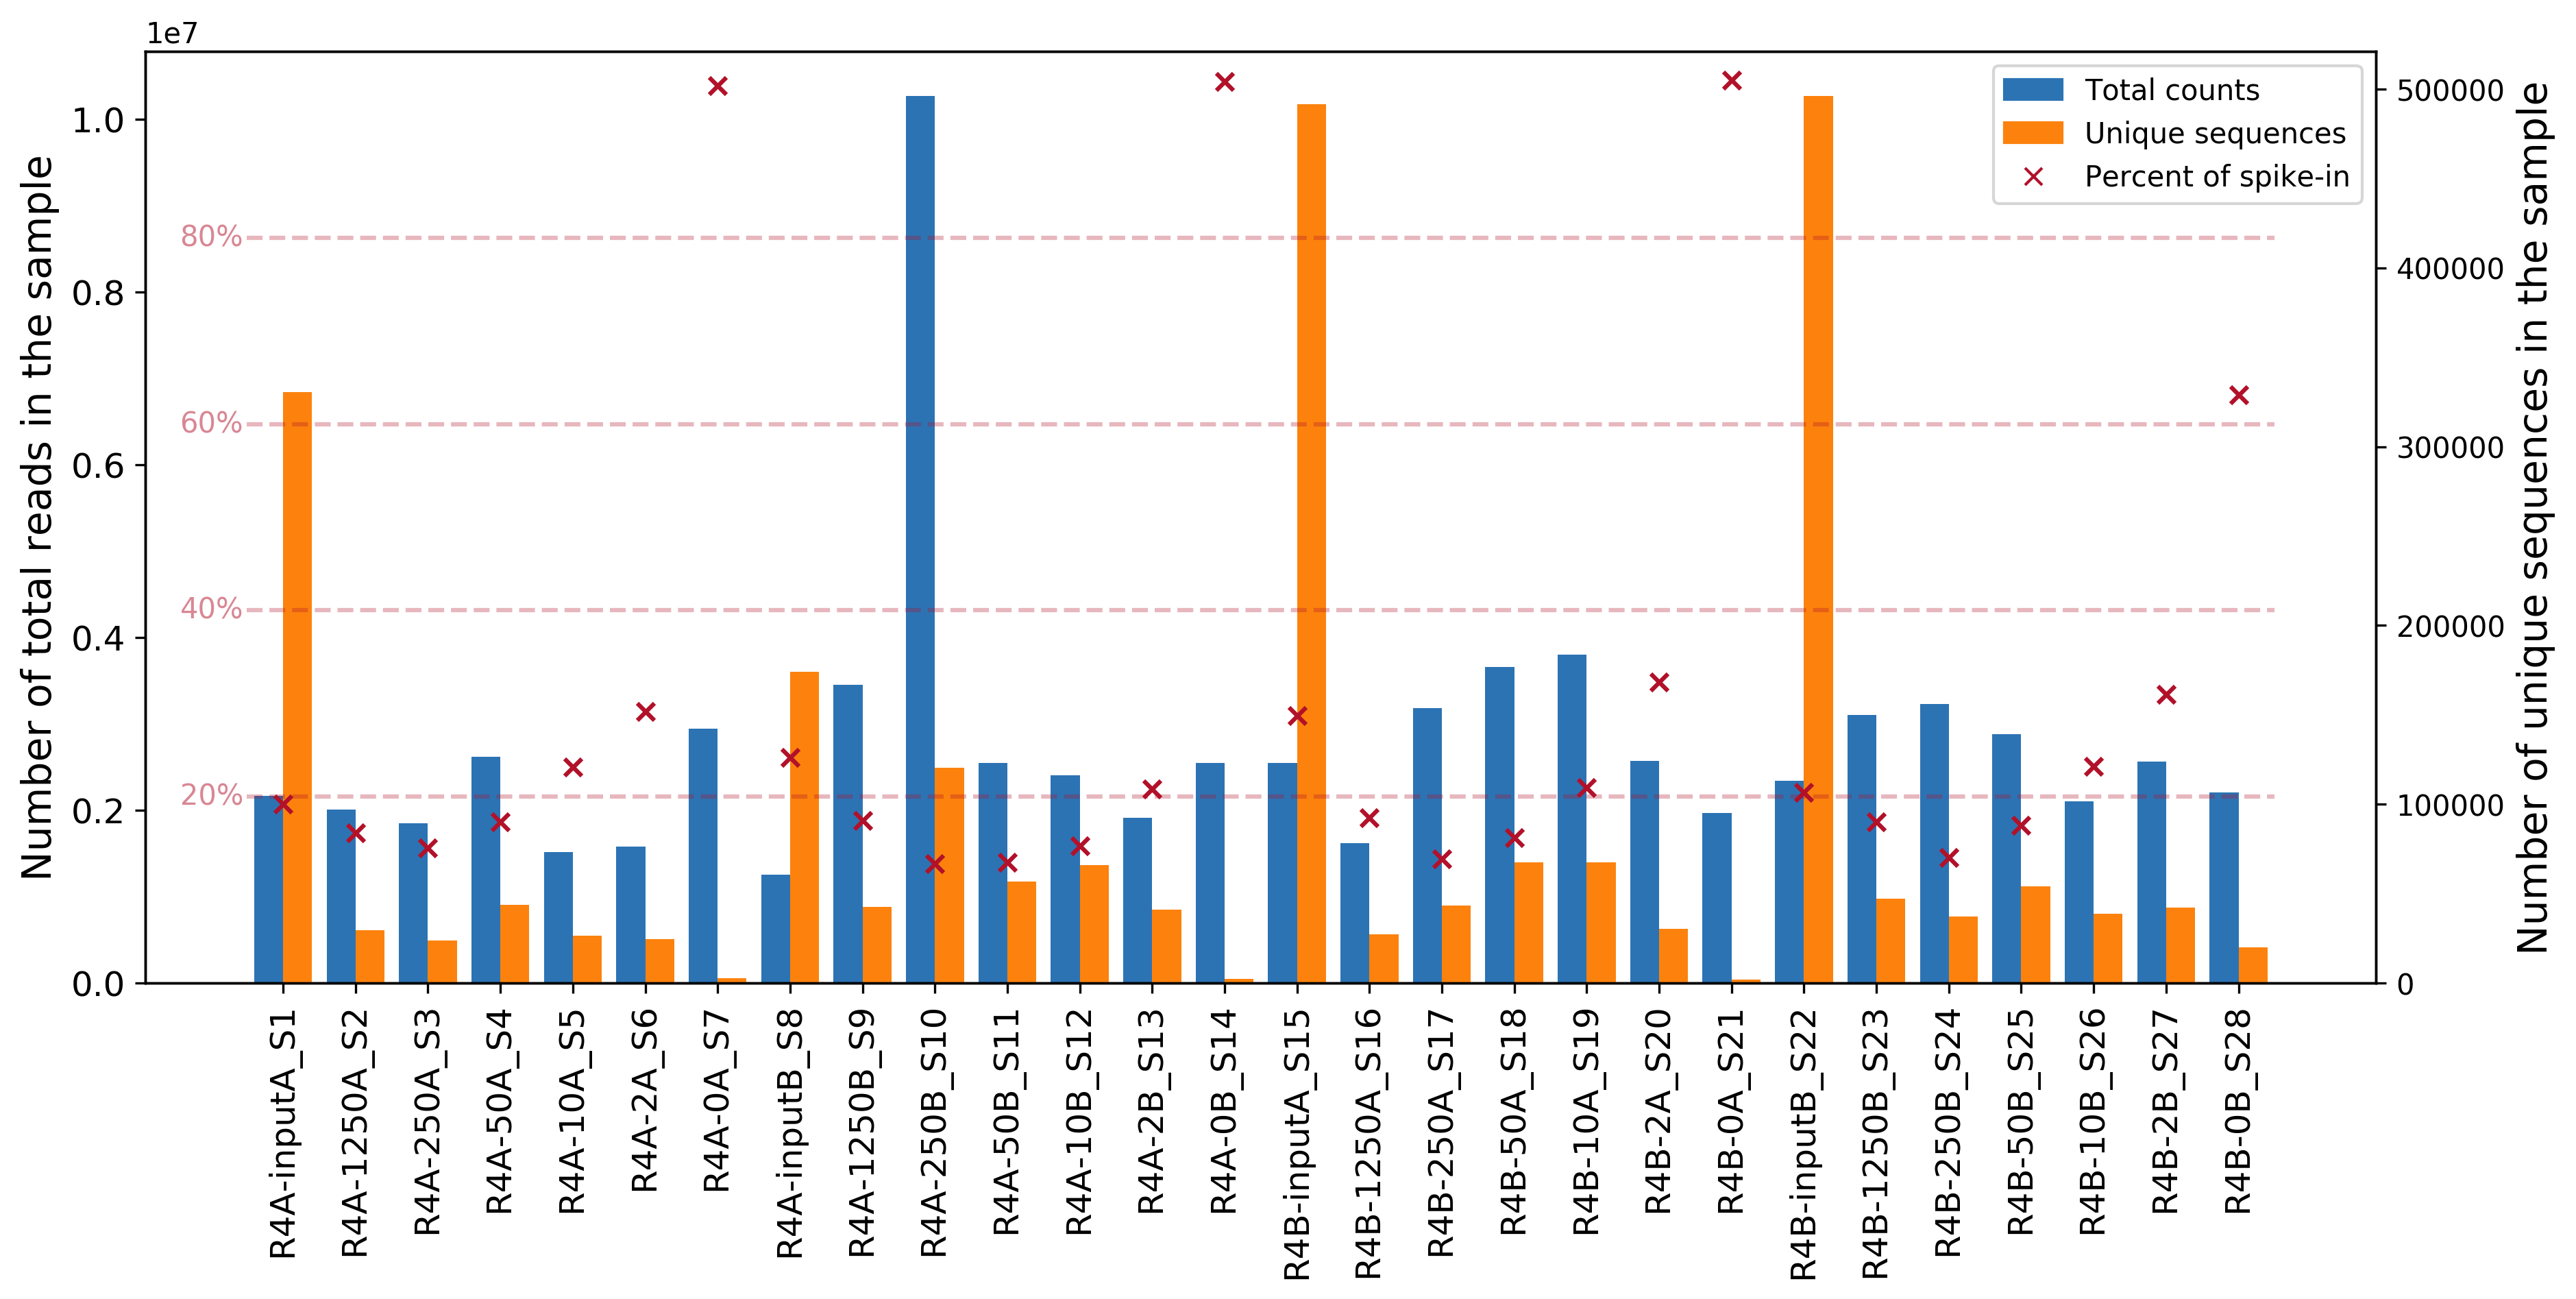

In [31]:
_ = analysis.sequencing_sample_info_table(sample_set)
analysis.sequencing_sample_info_plot(sample_set)

## Following are todos in this section

In [641]:
x = 2
print(x)
x = [x for _ in range(3)]
print(x)

2
[2, 2, 2]


## distribution of spike-in sequence

Check the distance of post-selection pool from **BYO** selection to spike-in


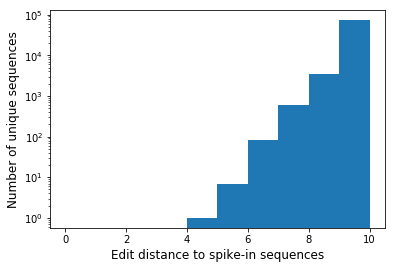

In [42]:
dirc = '/mnt/storage/projects/k-seq/input/byo_counts/R5c-counts.txt'
sample = data.read_count_file(dirc)
import Levenshtein
stdSeq='AAAAACAAAAACAAAAACAAA'
stdPeak = {}
for seq in sample['seqs'].items():
    dist = Levenshtein.distance(seq[0], stdSeq)
    if dist <= 10:
        stdPeak[seq[0]] = {
            'count': seq[1],
            'distance': dist
        }
        
import matplotlib.pyplot as plt
print(util.color.BOLD + util.color.BLUE + \
'Check the distance of post-selection pool from **BYO** selection to spike-in' + util.color.END)

distList = [seq['distance'] for seq in stdPeak.values()]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(distList, bins=np.linspace(0, 10, 11))
ax.set_yscale('log')
ax.set_ylabel('Number of unique sequences', fontsize=12)
ax.set_xlabel('Edit distance to spike-in sequences', fontsize=12)
plt.show()

Distribution of external standard peak


<Figure size 432x288 with 0 Axes>

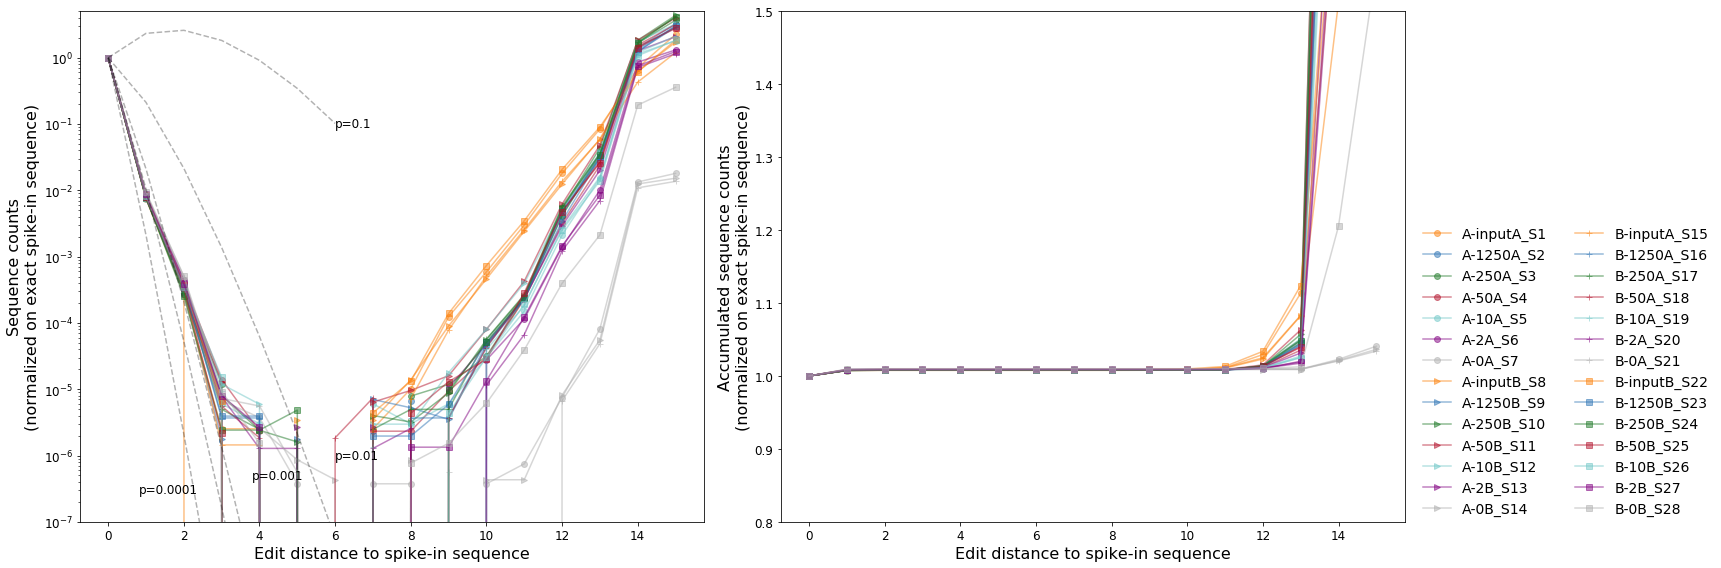

In [253]:
import util
print(util.color.BOLD + util.color.BLUE + 
      'Distribution of external standard peak'
      + util.color.END)
data.plot_std_peak_dist(sampleSet)

## Distribution of sample pools

Sequence length distribution in each sample


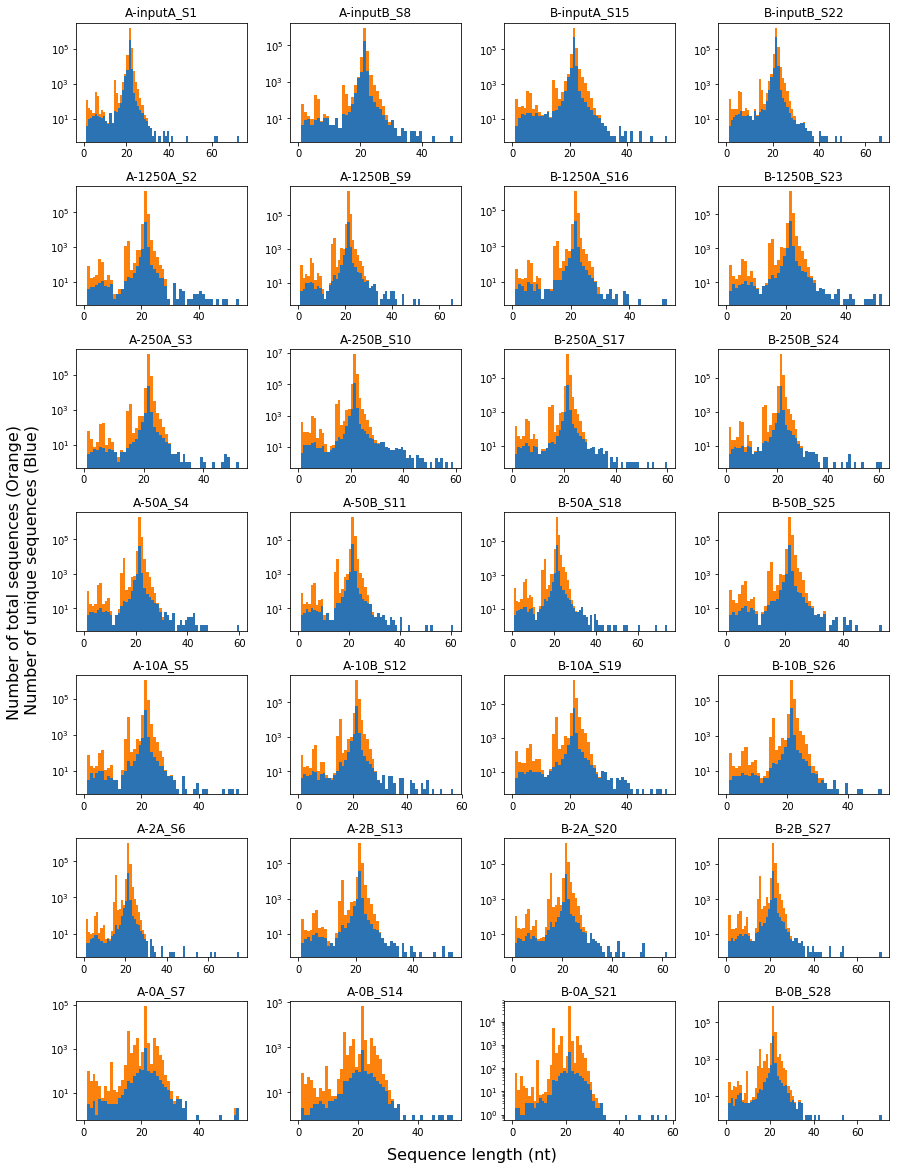

In [151]:
print(util.color.BOLD + util.color.BLUE + \
'Sequence length distribution in each sample' + util.color.END)
data.print_length_dist(sampleSet, total=True, unique=True, blackList=stdSeqList)

Sequence composition distribution in each sample


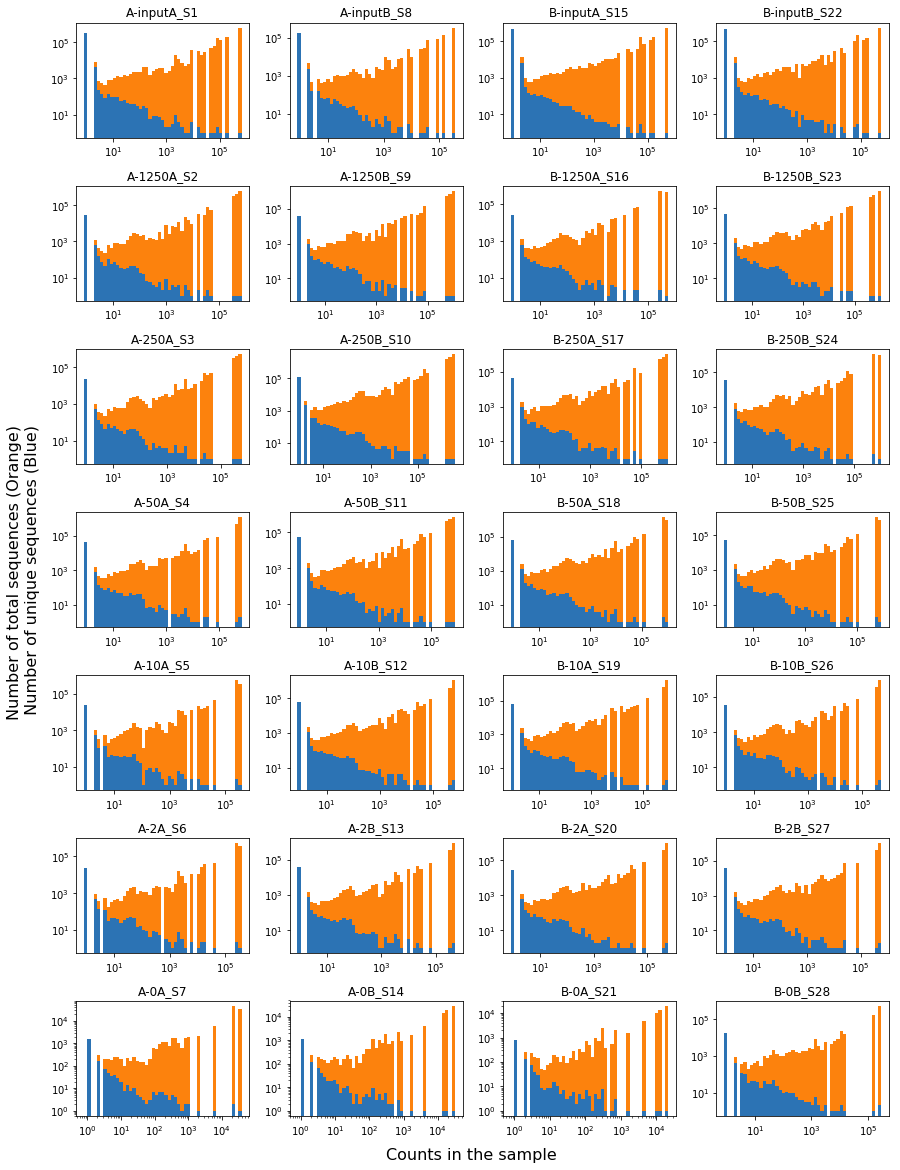

In [160]:
print(util.color.BOLD + util.color.BLUE + \
'Sequence composition distribution in each sample' + util.color.END)

data.print_composition_dist(sampleSet, total=True, unique=True, blackList=stdSeqList)

### Sequencing error adjustment

In [3]:
from scipy.stats import poisson
n = 4e5
p = 0.001/3
for k in [1,2,3,4,5]:
    mu = n*(1-p)**(21-k)*p**k
    rv = poisson(mu)
    print('{}: mu={}, p(>1)={:,.5f}, p(>10)={:,.5f}'.format(k, mu, 1-rv.cdf(1), 1-rv.cdf(10)))

1: mu=132.44725363759653, p(>1)=1.00000, p(>10)=1.00000
2: mu=0.04416380581447033, p(>1)=0.00095, p(>10)=0.00000
3: mu=1.472617733060031e-05, p(>1)=0.00000, p(>10)=0.00000
4: mu=4.910362564388232e-09, p(>1)=0.00000, p(>10)=0.00000
5: mu=1.6373332992291534e-12, p(>1)=0.00000, p(>10)=0.00000


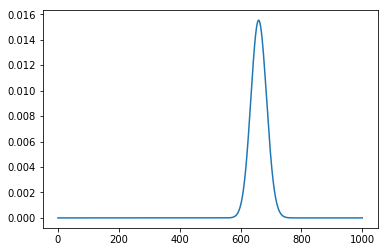

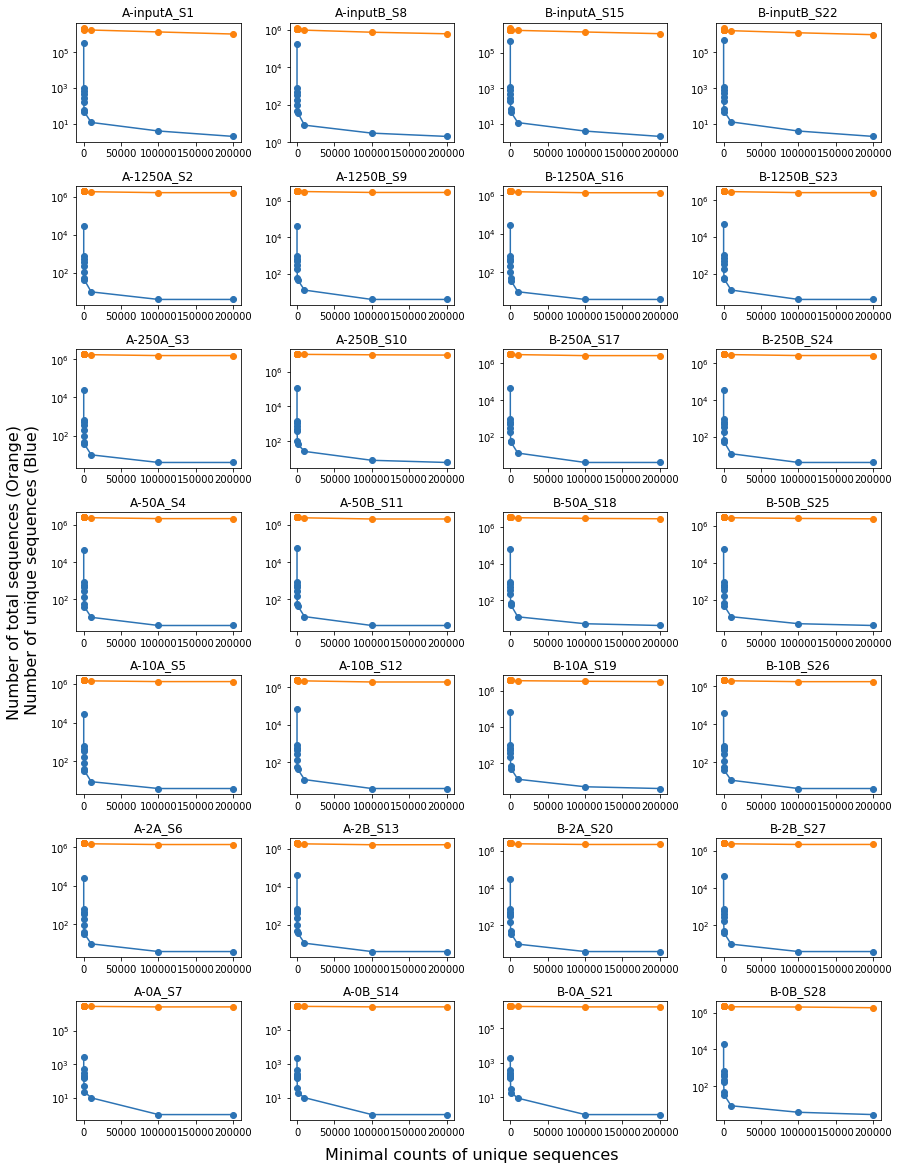

In [202]:
data.print_cutoff_changes(sampleSet=sampleSet)

Sequence length distribution in each sample (minimal sequence counts = 10)


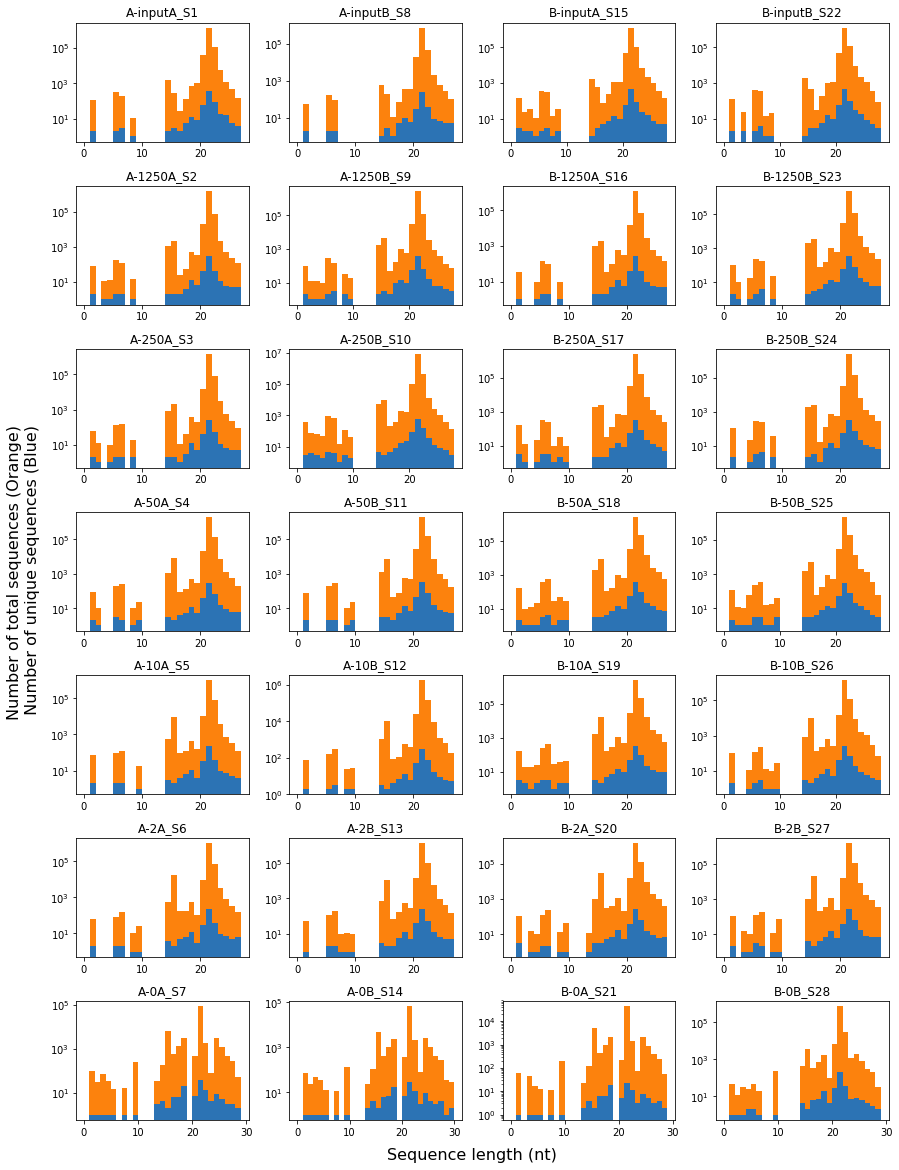

In [152]:
print(util.color.BOLD + util.color.BLUE + \
'Sequence length distribution in each sample (minimal sequence counts = 10)' + util.color.END)
data.print_length_dist(sampleSet, total=True, unique=True, minCounts=10, blackList=stdSeqList)

Sequence composition distribution in each sample


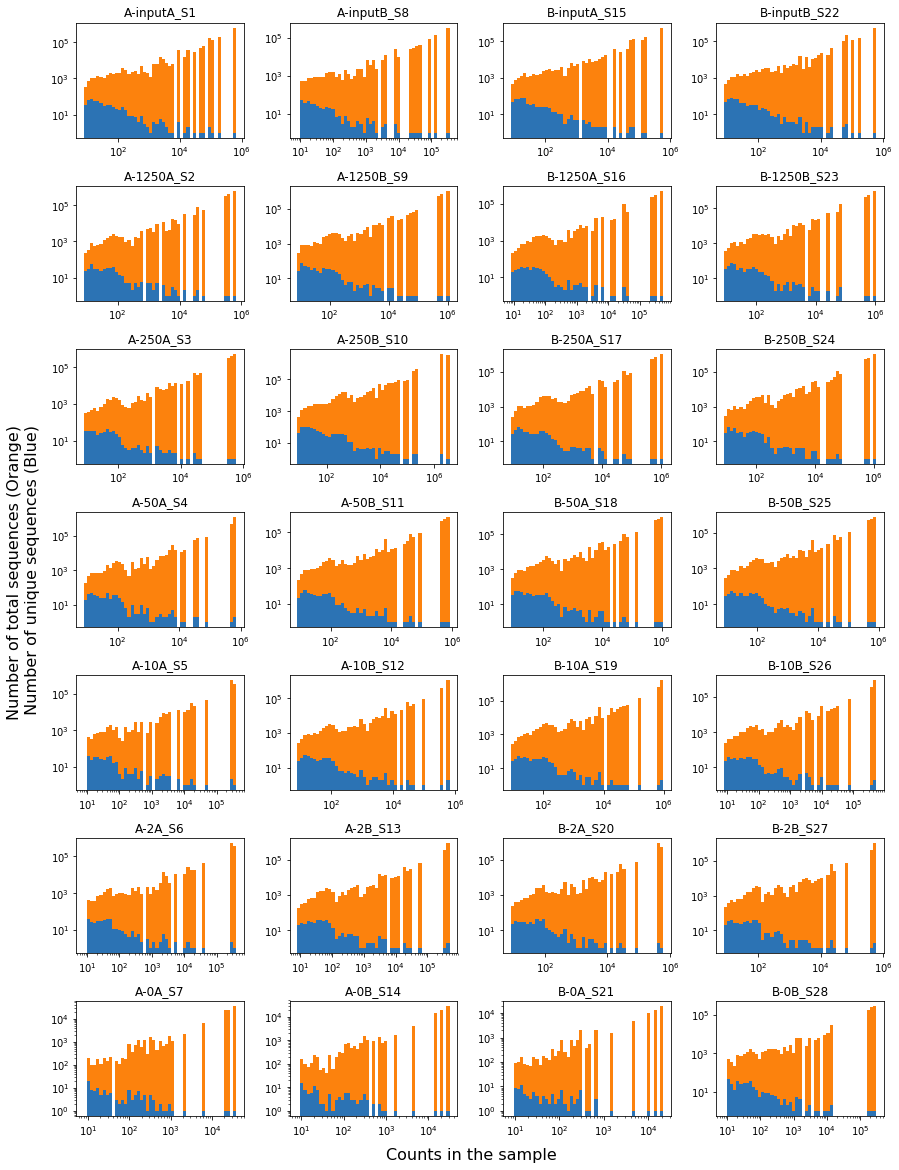

In [161]:
print(util.color.BOLD + util.color.BLUE + \
'Sequence composition distribution in each sample' + util.color.END)

data.print_composition_dist(sampleSet, minCounts=10, total=True, unique=True, blackList=stdSeqList)

In [268]:
sampleSet[0].seqs

{'CTACTTCAAACAATCGGTCTG': 605843,
 'AAAAACAAAAACAAAAACAAA': 395313,
 'ATTACCCTGGTCATCGAGTGA': 187328,
 'ATTACCCTGGTCATCGAGTGT': 122377,
 'ATTCACCTAGGTCATCGGGTG': 88556,
 'CTCTTCAAACAATCGGTCTTC': 84124,
 'ATTCACCTAGGTCATCGGGTGT': 63570,
 'CCACACTTCAAGCAATCGGTC': 46155,
 'CCGCTTCAAACAATCGGTTTG': 28860,
 'ATTCACCTAGGTCATCGAGTGT': 19347,
 'ACCCACTTCAAACAATCGGTC': 17460,
 'CACACTTCAAGCAATCGGTC': 15162,
 'CTGCTTCAAACAATCGGTGTG': 9758,
 'TACTTCAAACAATCGGTCTG': 9361,
 'ATTCACCTAGGTCATCGAGTGA': 8729,
 'CTACTTCAAACAATCGGTCTTC': 8534,
 'CTGTTTCAAACAATCGGTCTC': 6329,
 'CCACTTCAAACAATCGGTCTG': 4875,
 'ATTCACCTAGGTCATCGGGTGTT': 3694,
 'CCAGTCTTCAAACAATCGGTC': 3497,
 'AAAAAACAAAAACAAAAACAAA': 3417,
 'AAAACAAAAACAAAAACAAA': 3247,
 'TCTTCAAACAATCGGTCTTC': 3102,
 'CTGTTTCAAACAATCGGCCTG': 2965,
 'CTACTTCAAACAATCGGTCTC': 2842,
 'AGCCCGCTTCAAACAATCGGT': 2835,
 'CTCTTCAAACAATCGGTCTG': 2490,
 'TTACCCTGGTCATCGAGTGT': 2470,
 'CCAAACTTCAAACAATCGGTC': 2456,
 'CTGTTTCAAACAATCGGTCGC': 2444,
 'GTTACCCTGGTCATCGAGTGT

limit_output extension: Maximum message size of 10000 exceeded with 29651 characters

Use entropy efficiency to describe the distribution of sequences


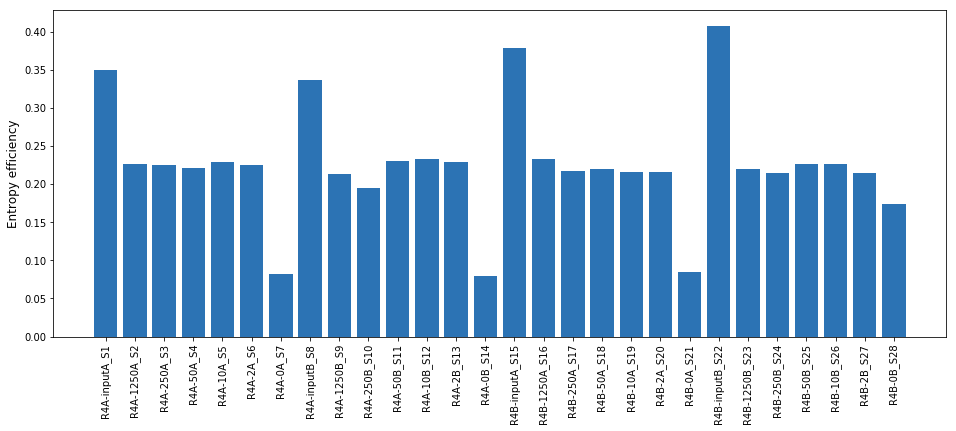

In [263]:
print(util.color.BOLD + util.color.BLUE + \
'Use entropy efficiency to describe the distribution of sequences' + util.color.END)


def bootstrap_fractions(fractions, size, depth=200):
    import numpy as np
    
    efficiencyList = []
    for _ in range(depth):
        sampleBootstrapped = np.random.choice([i for i in range(len(fractions))], p=fractions, replace=True, size=size)
        unique, counts = np.unique(sampleBootstrapped, return_counts=True)
        res = dict(zip(unique, counts))
        fractionsNew = [res[i]/size if i in res.keys() else 0 for i in range(len(fractions))]
        efficiencyList.append(-np.nansum(np.multiply(fractionsNew, np.log2(fractionsNew)))/np.log2(len(fractionsNew)))
    
    return efficiencyList

efficiencyList = bootstrap_fractions(sampleSet[0].get_seq_fraction(blackList='AAAAACAAAAACAAAAACAAA'), sampleSet[0].totalSeq)


fig = plt.figure(figsize=[16, 6])
ax = fig.add_subplot(111)

for ix in range(28):
    fractions = sampleSet[ix].get_seq_fraction()
    entropy_efficiency = -np.sum(np.multiply(fractions, np.log2(fractions)))/np.log2(len(fractions))
    plt.bar([ix], [entropy_efficiency], width=0.8, color='#2C73B4')

ax.set_xticks([i for i in range(28)])
ax.set_xticklabels([sample.id[:sample.id.find('_counts')] for sample in sampleSet], rotation=90)
ax.set_ylabel('Entropy efficiency', fontsize=12)
plt.show()

## Quantification factor

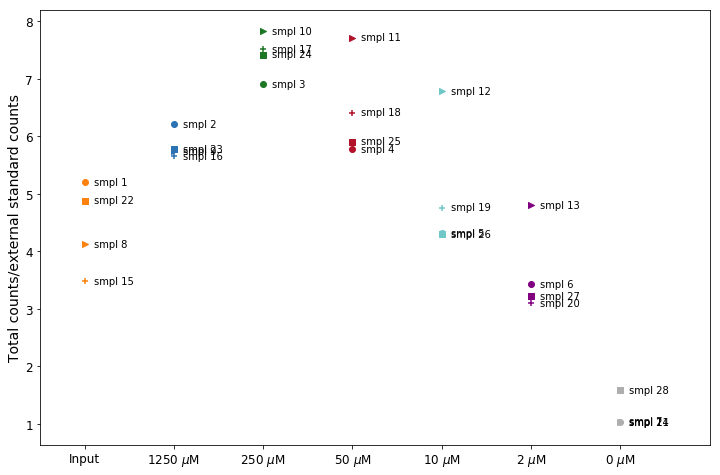

In [60]:
import matplotlib.pyplot as plt
import plot
rndToCal = [[i+1, i+8, i+15, i+22] for i in range(7)]

fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111)
markerList = ['o', '>', '+', 's']
colorList = ['#FC820D', '#2C73B4', '#1C7725', '#B2112A', '#70C7C7', '#810080', '#AEAEAE']
    
for ix, rndBatch in enumerate(rndToCal):
    for rndIx,rnd in enumerate(rndBatch):
        ax.scatter(ix, qFactorList[rnd-1][2]/qFactorList[rnd-1][1], marker=markerList[rndIx], color=colorList[ix])
        ax.text(s='smpl %i' %rnd, x=ix+0.1, y=qFactorList[rnd-1][2]/qFactorList[rnd-1][1], va='center', fontsize=10)
ax.set_xlim([-0.5, 7])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(['Input', r'1250 $\mu$M', r'250 $\mu$M', r'50 $\mu$M', r'10 $\mu$M', r'2 $\mu$M', r'0 $\mu$M'], fontsize=12)
ax.set_ylabel('Total counts/external standard counts', fontsize=14)
plot.set_ticks_size(ax,fontSizeY=12)

plt.show()

# Valid sequences analysis
## Convert valid sequences to ```sequence_set```

In [566]:
sequence_set = pre_processing.convert_samples_to_sequences(sample_set=sample_set, remove_spike_in=True)
sequence_set = pre_processing.survey_seqs_info(sequence_set)

## Valid sequence characterization

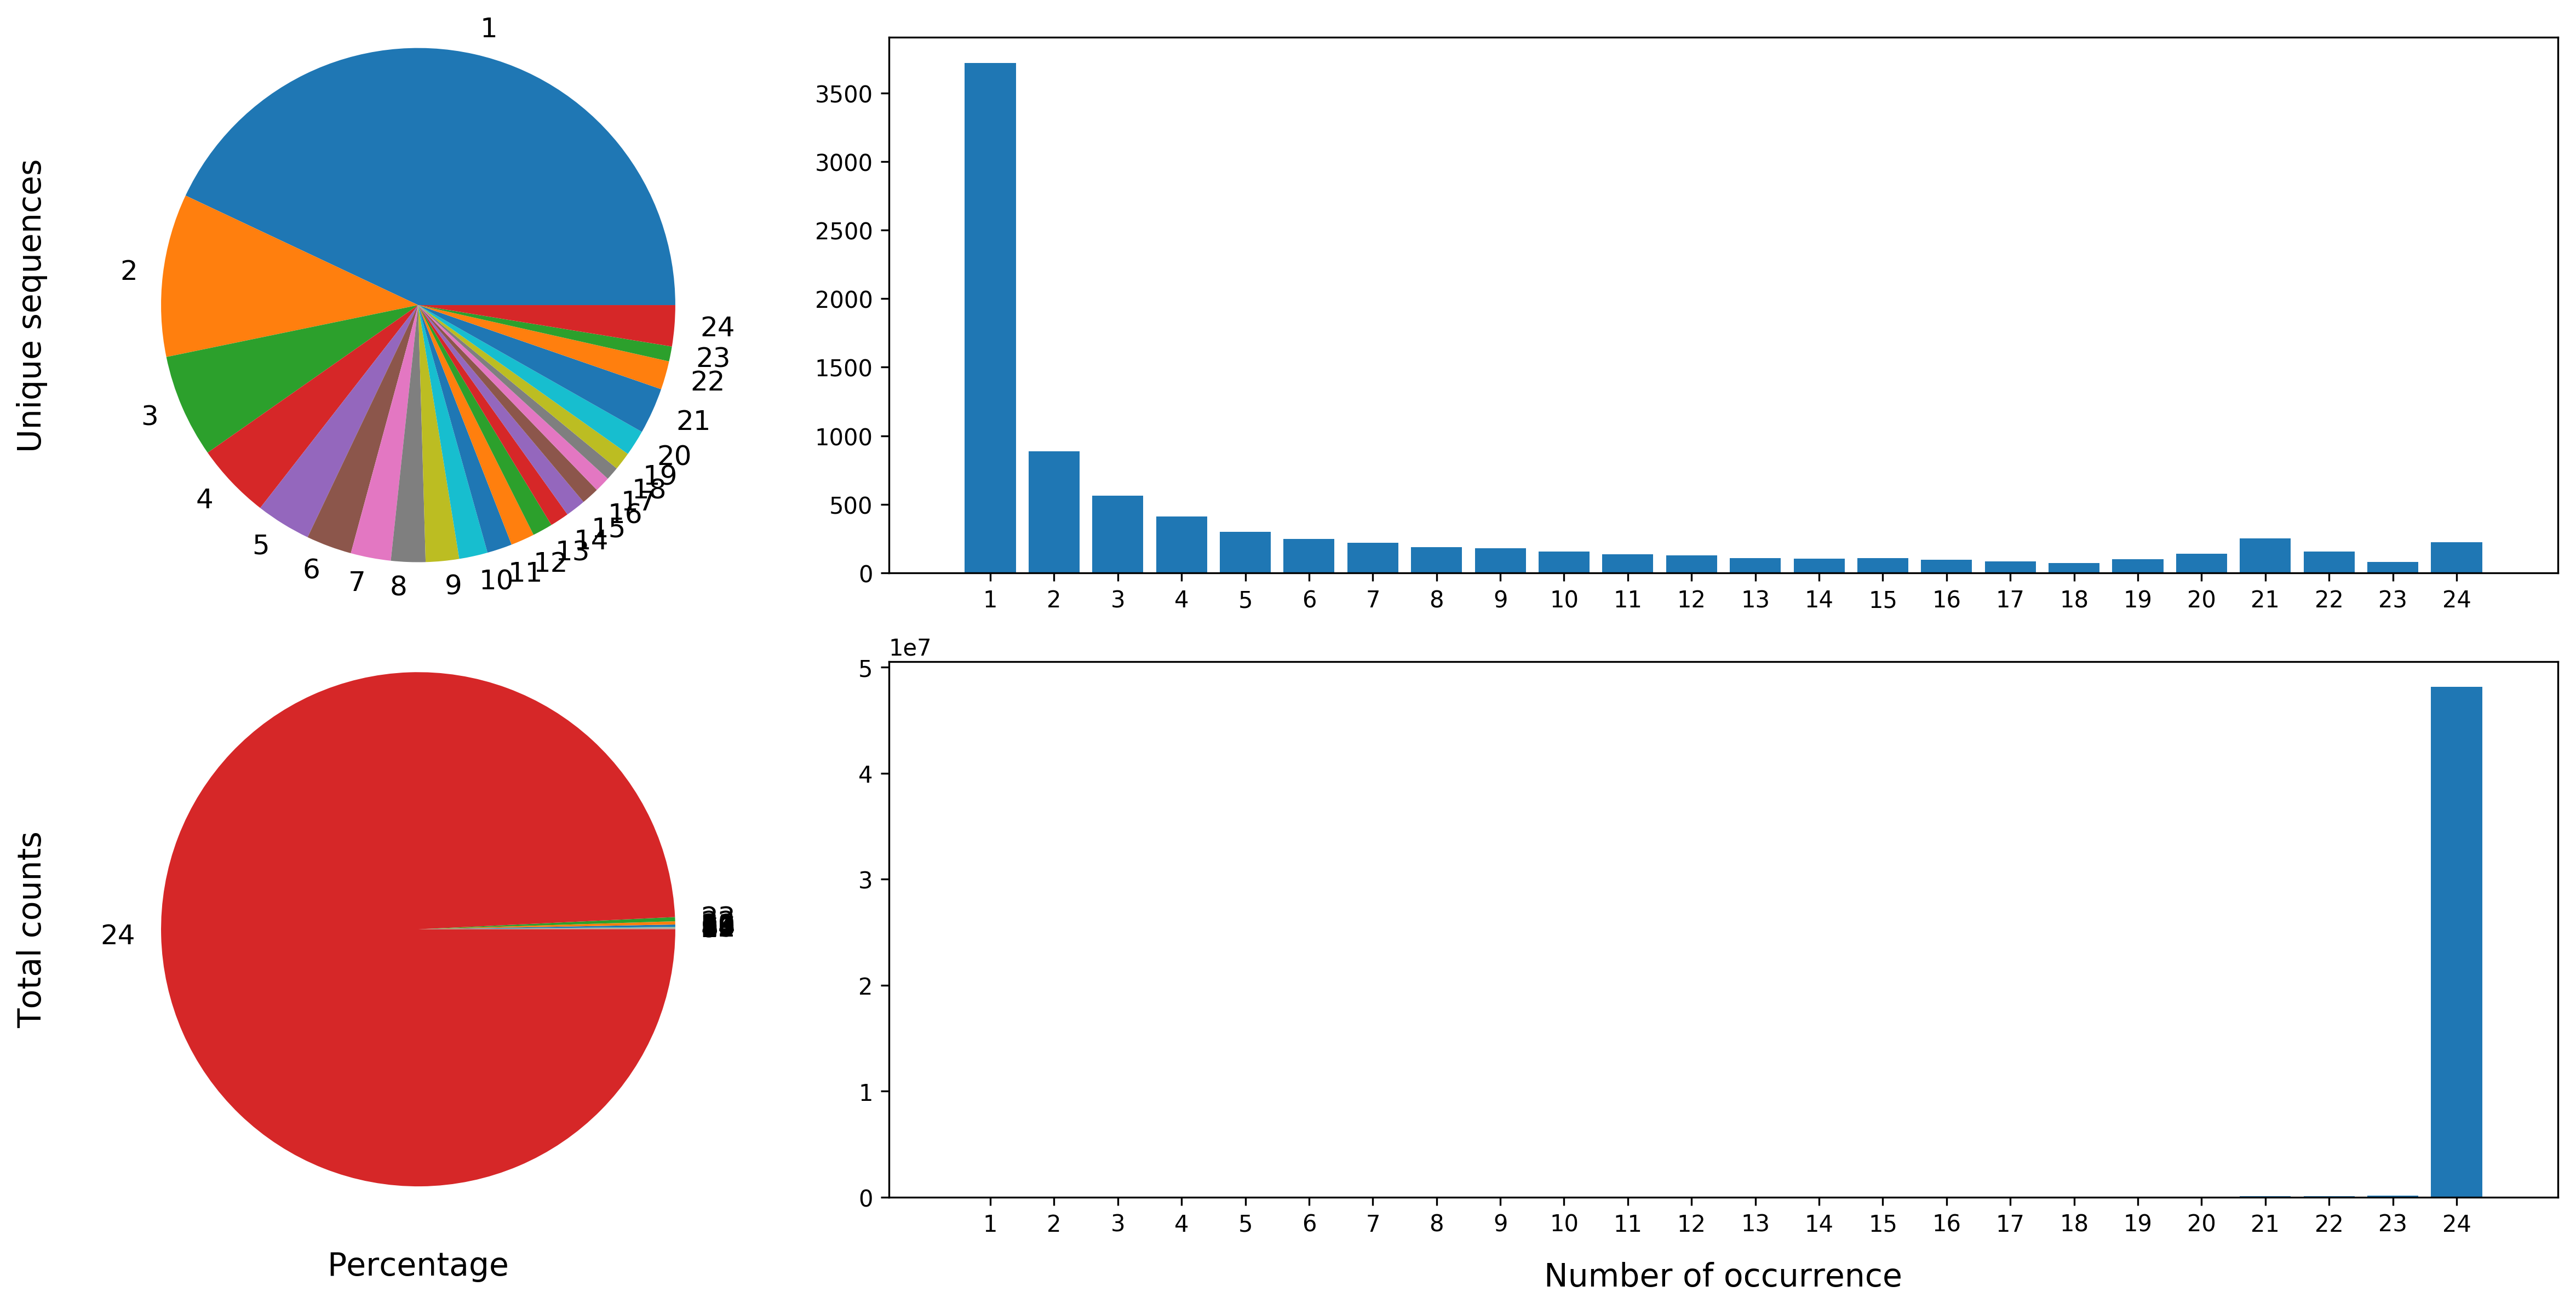

In [567]:
count_bins, count_bins_weighted = analysis.survey_seq_occurrence(sequence_set=sequence_set, display=True)

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


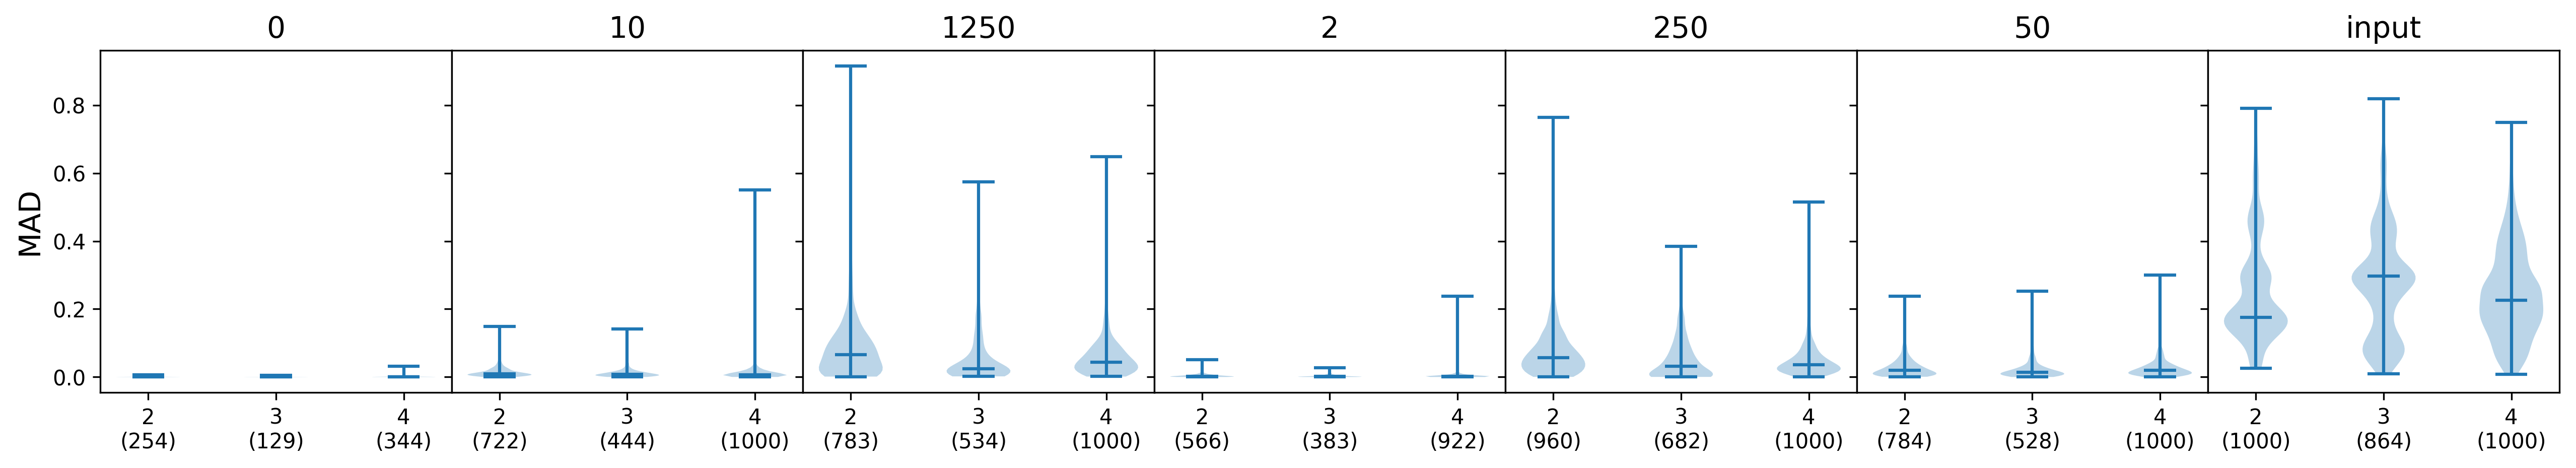

In [569]:
pre_processing.get_reacted_frac(sequence_set, inplace=True)
_ = analysis.analyze_rep_variability(sequence_set, display=True, key_domain='byo',percentage=False)

# Fitting

In [578]:
black_list = ['R4A-0B_S14', 'R4B-0A_S21', 'R4B-0B_S28']
seq = sequence_set.reacted_frac_table.loc['AGCCCGCTTCAAACAATCGGTT']

In [606]:
sample_set[0].__dict__.keys()

dict_keys(['file_dirc', 'unique_seqs', 'total_counts', 'sequences', 'name', 'metadata', 'sample_type', 'spike_in_counts', 'spike_in', 'quant_factor', 'quant_factor_max_dist', 'spike_in_amount'])

In [604]:
sequence_set.__dict__.keys()

dict_keys(['note', 'input_seq_num', 'reacted_seq_num', 'valid_seq_num', 'valid_seq_remove_spike_in', 'sample_info', 'count_table', 'seq_info', 'reacted_frac_table'])

In [600]:
[name for name in list(seq.index) if sequence_set.sample_info[name]['sample_type'] == 'input']

KeyError: 'input_median'

# Fitting results analysis

In [275]:
fittingRes = util.load_pickle(dirc='/mnt/storage/projects/ribozyme_predict/bfo/fittingRes_bfo_deep.pkl')

fittingRes_bfo_deep.pkl:
Fitting results of BFO data, including the CI 95 estimation using 1000 bootstrap, on Pod (40 cores)


In [638]:
sample_set[0].__dict__

{'file_dirc': '/mnt/storage/projects/k-seq/input/bfo_counts/counts/R4A-inputA_S1_counts.txt',
 'metadata': {'byo': 'input',
  'sample_id': 1,
  'select_rep': 'A',
  'sequence_rep': 'A'},
 'name': 'R4A-inputA_S1',
 'quant_factor': 4092157.4107959745,
 'quant_factor_max_dist': 2,
 'sample_type': 'input',
 'sequences': {'CTACTTCAAACAATCGGTCTG': 605843,
  'AAAAACAAAAACAAAAACAAA': 395313,
  'ATTACCCTGGTCATCGAGTGA': 187328,
  'ATTACCCTGGTCATCGAGTGT': 122377,
  'ATTCACCTAGGTCATCGGGTG': 88556,
  'CTCTTCAAACAATCGGTCTTC': 84124,
  'ATTCACCTAGGTCATCGGGTGT': 63570,
  'CCACACTTCAAGCAATCGGTC': 46155,
  'CCGCTTCAAACAATCGGTTTG': 28860,
  'ATTCACCTAGGTCATCGAGTGT': 19347,
  'ACCCACTTCAAACAATCGGTC': 17460,
  'CACACTTCAAGCAATCGGTC': 15162,
  'CTGCTTCAAACAATCGGTGTG': 9758,
  'TACTTCAAACAATCGGTCTG': 9361,
  'ATTCACCTAGGTCATCGAGTGA': 8729,
  'CTACTTCAAACAATCGGTCTTC': 8534,
  'CTGTTTCAAACAATCGGTCTC': 6329,
  'CCACTTCAAACAATCGGTCTG': 4875,
  'ATTCACCTAGGTCATCGGGTGTT': 3694,
  'CCAGTCTTCAAACAATCGGTC': 3497,
  '

limit_output extension: Maximum message size of 10000 exceeded with 31209 characters

In [615]:
import pickle

encoded = pickle.dumps(ob)
ob_recovered = pickle.loads(encoded)

'<__main__.SampleClass object at 0x7facc7122c18>'

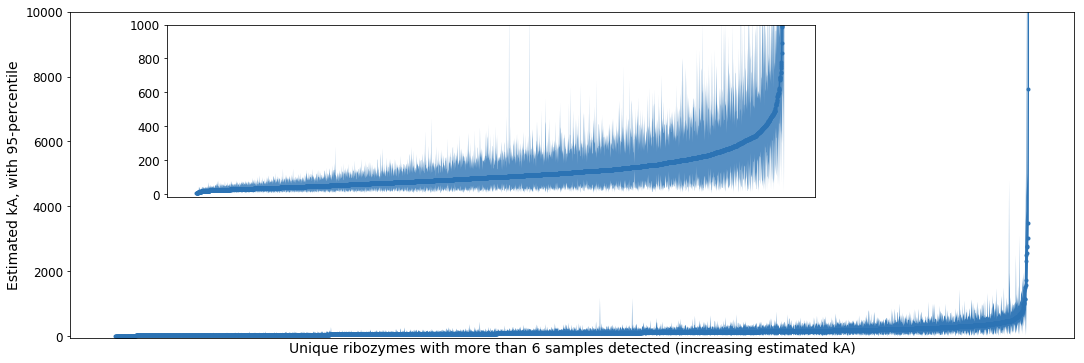

In [183]:
def filter_fn(res, percentile=True):
    if percentile:
        return [res['ci95'][2][3], res['ci95'][2][0], res['ci95'][2][2]]
    else:
        return [res['params'][2], res['params'][2]-2*res['stdevs'][2], res['params'][2]+2*res['stdevs'][2]]


def value_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    lowest = 0.01
    highest = 10
    
    fig = plt.figure(figsize=[18,6])
    ax = fig.add_subplot(111)
    ax.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    ax.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.95, facecolor='#2C73B4')
    plot.set_ticks_size(ax)
    ax.set_ylim([-50, 10000])
    ax.set_ylabel('Estimated kA, with 95-percentile', fontsize=14)
    ax.set_xticks([])
    ax.set_xlabel('Unique ribozymes with more than 6 samples detected (increasing estimated kA)', fontsize=14)
    axInset = fig.add_axes([0.2, 0.45, 0.5, 0.4])
    axInset.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    axInset.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.80, facecolor='#2C73B4')
    plot.set_ticks_size(axInset)
    axInset.set_ylim([-20, 1000])
    axInset.set_xticks([])
    
    # ax.set_xlim([25600,25750])
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_values_larg6_normality.png', dpi=300)
    plt.show()

surveyRes = []
# Only survey ribozymes at least detected 6 times and the CI can be estimated, return prediction and CI
for res in fittingRes:
    if np.sum(~np.isnan(res['kSeqFmol'])) >= 6 and ~np.isnan(res['params'][2]):
        if ~np.isnan(res['ci95'][2][1]):
            surveyRes.append(filter_fn(res))
sort_fn = lambda a: (a[0])
surveyRes.sort(key=sort_fn)

value_plot(surveyRes)

In [185]:
len(surveyRes)

3039

In [175]:
def get_config(res):
    return np.sum(~np.isnan(res['kSeqFmol'].reshape(4, 5)), axis=0)

def sort_fn(res):
    if np.isnan(res['params'][2]):
        return (0, 0)
    elif len(res['ci95'])==1:
        return (1, 0)
    else:
        return (1, res['ci95'][2][1])


def export_csv(fittingRes, dirc):
    fittingRes.sort(key=sort_fn, reverse=True)
    with open(dirc, 'w') as output:
        output.write('seq,inputCountMedian,config,kAEstimate,CIEstimate,k,A,kA,kA2.5,kA50,kA97.5,kAMean,k2.5,k50,k97.5,kMean,A2.5,A50,A97.5,AMean\n')
        for res in fittingRes:
            output.write('%s,%i,%s,' %(res['seq'], np.nanmedian(res['initRaw']), get_config(res)))
            if np.isnan(res['params'][2]):
                output.write('0,0,%s\n' %(','.join(['nan' for i in range(15)])))
            elif len(res['ci95'])==1:
                output.write('1,0,%f,%f,%f,%s\n' %(res['params'][0], res['params'][1], res['params'][2], ','.join(['nan' for i in range(12)])))
            else:
                output.write('1,1,%f,%f,%f,%s\n' %(res['params'][0], res['params'][1], res['params'][2],
                                                    ','.join(['%f'%i for i in list(res['ci95'][2]) + list(res['ci95'][0]) + list(res['ci95'][1])])))

export_csv(fittingRes, dirc='/mnt/storage/projects/ribozyme_predict/bfo/fittingRes.csv')

In [15]:
import pandas as pd

df = pd.read_csv('/mnt/storage/projects/ribozyme_predict/bfo/fittingRes.csv')

In [18]:
df.sort_values(by='inputCountMedian', ascending=False)

,seq,inputCountMedian,config,kAEstimate,CIEstimate,k,A,kA,kA2.5,kA50,kA97.5,kAMean,k2.5,k50,k97.5,kMean,A2.5,A50,A97.5,AMean
1949,CTACTTCAAACAATCGGTCTG,535826,[4 4 4 4 4],1,1,0.498193,185.846359,92.587327,64.435804,110.333514,172.973943,112.032047,NaN,0.582553,0.833534,0.600586,83.919158,192.976127,322.371536,192.997970
2248,AAAAACAAAAACAAAAACAAA,424144,[4 4 4 4 4],1,1,0.291822,134.625474,39.286699,29.450650,97.248256,221.326316,105.025213,0.368629,0.733697,1.000000,0.739579,32.178357,137.516680,423.558510,161.594631
282,ATTACCCTGGTCATCGAGTGA,166719,[4 4 4 4 4],1,1,0.897218,249.531760,223.884271,215.025539,352.185247,596.050062,367.764027,0.903414,1.000000,1.000000,0.993663,216.560758,355.083154,602.780817,370.170092
197,ATTACCCTGGTCATCGAGTGT,119288,[4 4 4 4 4],1,1,1.000000,284.907161,284.907161,293.761225,413.852201,676.772235,432.719099,1.000000,1.000000,1.000000,0.999463,293.761225,414.863798,676.772235,432.957706
4470,CTCTTCAAACAATCGGTCTTC,73892,[4 4 4 4 4],1,1,0.236052,116.392017,27.474539,19.776042,33.141220,59.958931,35.208687,0.216635,0.271530,0.458105,0.292468,47.977486,122.463424,227.548844,127.382156
3859,ATTCACCTAGGTCATCGGGTG,63062,[4 4 4 4 4],1,1,0.304344,116.469068,35.446720,26.988388,49.081517,97.616269,53.639380,0.294006,0.404862,0.767824,0.438493,37.610860,124.573785,257.007807,133.259215
1025,ATTCACCTAGGTCATCGGGTGT,62453,[4 4 4 4 4],1,1,0.298714,559.444397,167.113692,134.185163,176.329546,284.608795,186.155354,0.284175,0.328169,0.397175,0.330130,360.990341,546.440081,923.819656,571.004964
4493,CCACACTTCAAGCAATCGGTC,50627,[4 4 4 4 4],1,1,0.140133,195.437983,27.387217,16.717935,32.597901,55.281122,33.206819,0.128337,0.162480,0.259436,0.171929,69.150021,210.763949,363.453127,204.490103
1738,CCGCTTCAAACAATCGGTTTG,33567,[4 4 4 4 4],1,1,0.471540,220.232388,103.848293,69.467598,120.279570,180.443176,120.908248,0.447817,0.545243,0.739890,0.556521,104.960830,224.587700,352.346250,223.069532
1028,ATTCACCTAGGTCATCGAGTGT,18526,[4 4 4 4 4],1,1,0.416950,381.886042,159.227321,103.883256,175.772415,278.100993,182.805232,0.404696,0.471860,0.610054,0.481229,172.178304,378.198487,612.157516,386.911850


limit_output extension: Maximum message size of 10000 exceeded with 33203 characters

In [19]:
len(df)

9086

In [34]:
def filter_fn(seq):
    return np.sum([int(seq[1]['config'][i]) for i in [1,3,5,7]])>=6

dfNew = df[[filter_fn(seq) for seq in df.iterrows()]]

In [38]:
dfNew.sort_values(by='kA', ascending=False)

,seq,inputCount,config,kAEstimate,CIEstimate,k,A,kA,kSD,ASD,...,kA97.5,kAMean,k2.5,k50,k97.5,kMean,A2.5,A50,A97.5,AMean
39,TGATTTCAAGCAATCGGTCTG,1,[3 1 2 0],1,1,47393.092714,0.023731,1124.681409,18558.252350,0.005864,...,1361.143523,521.758719,336.607840,22355.410823,44230.315533,21636.397353,0.014261,0.025108,0.037842,0.025552
0,CCAAAACTTCAAACAATCGGTC,6,[6 5 3 4],1,1,715.681578,1.000000,715.681578,14192.261172,0.128773,...,9981.876047,3705.642877,281.647950,2350.794557,11038.902086,4638.638897,0.485171,1.000000,1.000000,0.963271
1,CCGCTTCAAATCGGTTTG,1,[4 3 1 4],1,1,588.307672,1.000000,588.307672,14476.015536,0.142513,...,6712.771984,2739.551729,309.639914,2205.351800,7419.087659,3769.991121,0.342088,1.000000,1.000000,0.964377
513,ACTTCAAACAATCGATCGGCA,1,[1 3 2 0],1,1,37924.521060,0.011610,440.293696,18449.329375,0.002689,...,638.036378,254.122432,335.333375,13614.048748,44350.154713,21437.002189,0.008136,0.012399,0.018362,0.012786
3,CTACTTCAAATCGGTCTG,2,[5 4 0 4],1,1,408.258222,1.000000,408.258222,15852.336184,0.210323,...,2712.748157,1418.313756,168.848633,1581.160551,3511.853783,2809.306485,0.217108,1.000000,1.000000,0.916502
30,CCAAGTTTTCAAACAATCGGTC,1,[6 5 3 4],1,1,356.832986,1.000000,356.832986,590.956533,0.191603,...,1350.925294,569.515200,167.315436,502.858706,1987.092234,716.938083,0.398787,1.000000,1.000000,0.883993
27,CCGCACTTCAAGCAATCGGTCT,1,[6 5 3 4],1,1,354.696222,1.000000,354.696222,342.534403,0.136793,...,1132.152394,551.457801,218.996384,513.916775,1462.212706,623.362779,0.553848,1.000000,1.000000,0.923439
23,CCGCTTCACAATCGGTTTG,1,[6 4 3 4],1,1,339.557477,1.000000,339.557477,6820.497223,0.246945,...,3207.372280,1005.406558,91.331007,606.428400,6269.464857,1570.800522,0.197823,1.000000,1.000000,0.858887
99,GCTTCAACCAATCGGTCCGCC,1,[6 5 3 4],1,1,273.434894,1.000000,273.434894,167.654734,0.136158,...,541.186190,317.409512,182.031658,330.960269,887.178090,369.019676,0.551678,1.000000,1.000000,0.902670
58,CCGCTTCAAACAATCCGTTTG,3,[6 5 3 4],1,1,255.810825,1.000000,255.810825,111.381041,0.099733,...,492.922997,337.307955,211.121819,345.340360,643.187739,362.684423,0.649195,1.000000,1.000000,0.948428


limit_output extension: Maximum message size of 10000 exceeded with 31468 characters

# Compare to gel shift data

In [296]:
selectedSeq = [
    ('S-2.1-a', 'ATTACCCTGGTCATCGAGTGA'),
    ('S-2.1-b', 'ATTACCCTGGTCATCGAGTGT'),
    ('S-1A.1-a', 'CTACTTCAAACAATCGGTCTG'),
    ('S-1B.1-a', 'CCACACTTCAAGCAATCGGTC'),
    ('S-1B.2-a', 'CCGCTTCAAGCAATCGGTCGC'),
    ('S-1B.3-a', 'CCGAGTTTCAAGCAATCGGTC'),
    ('S-3.1-a', 'AAGTTTGCTAATAGTCGCAAG'),
    ('S-2.2-a', 'ATTCACCTAGGTCATCGGGTG'),
    ('S-1A.4-a', 'CTCTTCAAACAATCGGTCTTC'),
    ('S-1C.1-a', 'CTCTTCAATAATCGGTTGCGT')
]
reactedFrac = {
    'S-2.1-a': [[0.4893, 0.4193, 0.3054, 0.1202, 0.0359, 0.0162],
                [0.4786, 0.4031, 0.2747, 0.1029, 0.0331, 0.0172],
                [0.4896, 0.4268, 0.3014, 0.1174, 0.0340, 0.0151]],
    'S-2.1-b': [[0.2477, 0.1705, 0.1003, 0.0492, 0.0275, 0.0187],
                [0.2290, 0.1519, 0.0899, 0.0340, 0.0123, 0.0173],
                [0.2314, 0.1497, 0.0849, 0.0334, 0.0155, 0.0117]],
    'S-1A.1-a': [[0.2450, 0.1674, 0.0958, 0.0488, 0.0278, 0.0189],
                 [0.2305, 0.1473, 0.0864, 0.0334, 0.0122, 0.0175],
                 [0.2315, 0.1429, 0.0811, 0.0328, 0.0155, 0.0118]],
    'S-1B.1-a': [[0.4162, 0.1841, 0.0681, 0.0283, 0.0042, 0.0046],
                 [0.4552, 0.2185, 0.0659, 0.0253, 0.0148, 0.0134]],
    'S-1B.2-a': [[0.3914, 0.1579, 0.0516, 0.0329, 0.0310, 0.0280],
                 [0.4325, 0.1857, 0.0529, 0.0213, 0.0171, 0.0195]],
    'S-1B.3-a': [[0.3929, 0.1580, 0.0509, 0.0331, 0.0318, 0.0287],
                 [0.4216, 0.1837, 0.0525, 0.0212, 0.0172, 0.0197]]
}
selectedSeq = {
    seq[0]:{
        'seq': seq[1]
    } for seq in selectedSeq
}
for seq in reactedFrac.items():
    selectedSeq[seq[0]]['gelRaw'] = np.array(seq[1])
xValues = [0.00125, 0.00025, 0.00005, 0.00001, 0.000002, 0] # in M
for seqId in selectedSeq.keys():
    selectedSeq[seqId]['kSeqRes'] = fittingRes[selectedSeq[seqId]['seq']]

seqFinished = ['S-1B.3-a', 'S-1B.2-a', 'S-1B.1-a', 'S-1A.1-a', 'S-2.1-b', 'S-2.1-a']

In [327]:
import fitting.bootstrap as bs
importlib.reload(bs)

for seqId in seqFinished:
    # generate sample points exclude the concentration 0
    shape = np.shape(selectedSeq[seqId]['gelRaw'])
    xdata = np.tile(xValues[:-1], shape[0])
    ydata = np.reshape(selectedSeq[seqId]['gelRaw'][...,:-1], shape[0]*(shape[1]-1))
    selectedSeq[seqId]['gelRes'] = bs.fitting(ydata=ydata, xdata=xdata)

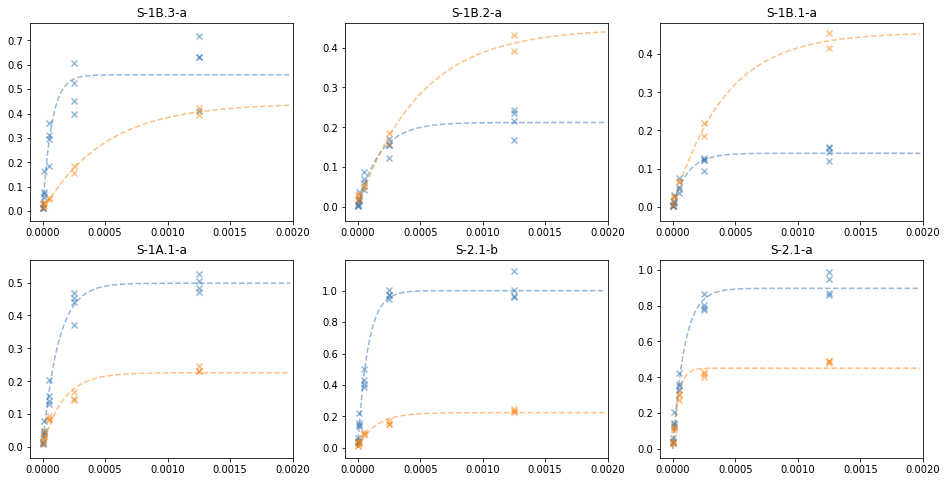

In [337]:
import matplotlib.pyplot as plt

def exp_func(x, A, k):
    return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BTO degradation adjustment and 90 minutes

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for ix, seqId in enumerate(seqFinished):
    ax = axes[int(ix/3), ix%3]
    ax.set_title(seqId, fontsize=12)
    ### Plot k-seq data
    xdata = np.tile(xValues[:-1], 4)
    ydata = selectedSeq[seqId]['kSeqRes']['reactedFrac']
    ax.scatter(xdata, ydata, marker='x', color='#2C73B4', alpha=0.5)
    x = np.arange(0, 0.00200, 0.002/100)
    ax.plot(x, exp_func(x, selectedSeq[seqId]['kSeqRes']['params'][0], selectedSeq[seqId]['kSeqRes']['params'][1]), color='#2C73B4', ls='--', alpha=0.5)
    ax.set_xlim([-0.0001, 0.002])
    
    ### Plot gel data
    shape = np.shape(selectedSeq[seqId]['gelRaw'])
    xdata = np.tile(xValues[:-1], shape[0])
    ydata = np.reshape(selectedSeq[seqId]['gelRaw'][...,:-1], shape[0]*(shape[1]-1))
    ax.scatter(xdata, ydata, marker='x', color='#FC820D', alpha=0.5)
    x = np.arange(0, 0.00200, 0.002/100)
    ax.plot(x, exp_func(x, selectedSeq[seqId]['gelRes']['params'][0], selectedSeq[seqId]['gelRes']['params'][1]), color='#FC820D', ls='--', alpha=0.5)

plt.show()

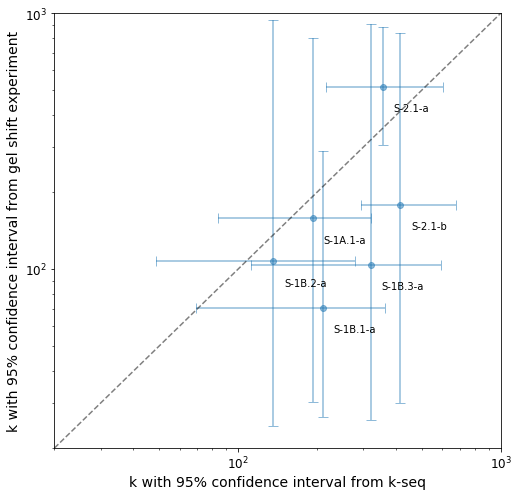

In [373]:
import plot
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111)
param=1
reskSeq = [selectedSeq[seqId]['kSeqRes']['ci95'][param][1] for seqId in seqFinished]
reskSeq95 = [(selectedSeq[seqId]['kSeqRes']['ci95'][param][1] - selectedSeq[seqId]['kSeqRes']['ci95'][param][0], selectedSeq[seqId]['kSeqRes']['ci95'][param][2] - selectedSeq[seqId]['kSeqRes']['ci95'][param][1]) for seqId in seqFinished]
resGel = [selectedSeq[seqId]['gelRes']['ci95'][param][1] for seqId in seqFinished]
resGel95 = [(selectedSeq[seqId]['gelRes']['ci95'][param][1] - selectedSeq[seqId]['gelRes']['ci95'][param][0], selectedSeq[seqId]['gelRes']['ci95'][param][2] - selectedSeq[seqId]['gelRes']['ci95'][param][1]) for seqId in seqFinished]
ax.errorbar(x=reskSeq, y=resGel, xerr=np.array(reskSeq95).T, yerr=np.array(resGel95).T, marker='o', linestyle='', capsize=5, alpha=0.5)
plot.set_ticks_size(ax)

for seqId in seqFinished:
    ax.text(s=seqId, x=selectedSeq[seqId]['kSeqRes']['ci95'][param][1]*1.1, y=selectedSeq[seqId]['gelRes']['ci95'][param][1]*0.8)
ax.plot([0, 1000], [0, 1000], 'k--', alpha=0.5)
ax.set_ylim([20, 1000])
ax.set_xlim([20, 1000])
ax.set_yscale('log')
ax.set_xscale('log')
paramDict = {0:'A', 1:'k', 2:'kA'}
ax.set_xlabel('{} with 95% confidence interval from k-seq'.format(paramDict[param]), fontsize=14)
ax.set_ylabel('{} with 95% confidence interval from gel shift experiment'.format(paramDict[param]), fontsize=14)

plt.show()

# The rough error correction

In [27]:
import pandas as pd
seqRes = pd.read_csv('/mnt/storage/projects/ribozyme_predict/bfo/fittingRes.csv')
seqRes

,seq,inputCountMedian,config,kAEstimate,CIEstimate,k,A,kA,kA2.5,kA50,kA97.5,kAMean,k2.5,k50,k97.5,kMean,A2.5,A50,A97.5,AMean
0,AAAAACAAAAACAAA,151,[4 4 4 4 4],1,1,1.000000,123755.179708,123755.179708,129963.510685,138699.361371,146385.826918,138597.222743,1.000000,1.000000,1.000000,1.000000,129963.510685,138699.361371,146385.826918,138597.222743
1,ATTACCCTGGTCATCGAGTT,2,[4 4 4 4 4],1,1,1.000000,2297.589821,2297.589821,3094.024975,7730.971132,11911.680373,7608.926988,1.000000,1.000000,1.000000,1.000000,3094.024975,7730.971132,11911.680373,7608.926988
2,CACCCCGCTTCAAGCAATCGGT,1,[0 0 1 1 0],1,1,0.138958,43192.305540,6001.898690,668.666658,5055.095801,7370.879593,4522.719782,0.128003,0.138958,0.149922,0.141469,4460.087662,38487.154652,53044.093481,32513.867477
3,CCGCTCCAAACAATCGGTCTG,1,[1 0 1 0 0],1,1,0.426227,9098.112658,3877.860461,526.192715,3491.741736,4746.371384,2942.718342,0.409054,0.443400,0.443400,0.430640,1186.722336,8094.744052,11135.785391,6888.272387
4,AAAACAAAAACAAA,4,[4 4 4 4 4],1,1,0.934998,3108.542828,2906.481330,2136.059114,3344.093768,5472.631662,3481.063385,0.870602,1.000000,1.000000,0.978981,2149.704104,3411.891880,5736.717160,3566.128118
5,AAAAACAAAAACAA,1,[4 4 4 4 4],1,1,0.660811,4281.522551,2829.279200,1598.148491,3033.519618,4579.603208,3010.053437,0.554811,0.686282,0.813236,0.687611,2127.419485,4343.537263,7585.463114,4453.953178
6,ATTCCCTGGTCATCGAGTGT,2,[4 4 4 4 4],1,1,1.000000,1356.015769,1356.015769,1421.802558,2606.696101,4707.916719,2747.671672,1.000000,1.000000,1.000000,0.999569,1431.698219,2606.696101,4746.367457,2749.142168
7,AAATTCAAAAACAAAAACAAA,2,[4 3 4 4 4],1,1,1.000000,1003.911278,1003.911278,1468.302610,2583.833720,5003.948320,2794.020806,1.000000,1.000000,1.000000,0.999746,1468.302610,2583.833720,5003.948320,2794.842354
8,ATTACCCT,1,[4 4 4 4 4],1,1,1.000000,1388.450252,1388.450252,1328.299505,2418.582947,4286.776280,2557.514435,1.000000,1.000000,1.000000,0.999460,1328.299505,2419.227833,4286.776280,2558.689602
9,CCCCTTCAATAATCGGTCATG,1,[1 0 1 0 0],1,1,0.281735,9705.618204,2734.416786,327.543407,2311.852435,2971.648974,1899.716078,0.268227,0.281735,0.295244,0.285315,1109.397633,7977.671867,10547.656863,6725.301205


limit_output extension: Maximum message size of 10000 exceeded with 31107 characters

In [ ]:
def seq_err_est_rough(seqList, pErrTotal, pErrLambda):
    """
    A rough method to estimate if a sequence can be possibly come from an error; If yes, label
    """
    
    def get_transition_probability(centerSeq, testSeq, pErrTotal, pErrLambda):
        import Levenshtein
        
        edits = Levenshtein.editops(centerSeq, testSeq)
        d1 = np.sum([1 for edit in edits if edit[0]=='replace'])
        d2 = len(edits) - d1
        return (1-pErrTotal)**len(centerSeq), (pErrLambda*pErrTotal/3)**d1*((1-pErrLambda)pErrTotal/2)**d2*(1-pErrTotal)**(len(centerSeq)-d1-d2)
    
    def test_end(seqList):
        while 
        for seq in seqList.iterrow():
            if pErrTotal**(len(seq['seq'])-1)(1-pErrTotal)*seq['inputCountMedian']:
                
        
        
        
    